## Logging and plotting data

In the previous practical sessions we saw how to define, attach, start, stop and detach routines to the robot robots. Here we are going to see how to use such routines to record data perceived or produced by the robots. This will allow the plotting of figures in the notebook. This can also be useful to better visualize what is happening in your simulation and help you debugging it. 

Let's start with a simple example where we record the values returned by both proximeters through time. In V-REP, load the scene called `robot-scene-5.ttt` in `pyvrep_robot/vrep_scenes`. Then connect to the simulator as usual:

In [20]:
# for this notebook
robots_id = 0
ressources = 1 
s_obstacles = 2
b_obstacles = 3

In [1]:
from vivarium.controllers.notebook_controller import NotebookController
from vivarium.utils.handle_server_interface import start_server_and_interface, stop_server_and_interface

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [22]:
start_server_and_interface(scene_name="session_4")

STARTING SERVER


An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


[2024-10-21 16:49:49,671][__main__][INFO] - Scene running: session_4
[2024-10-21 16:49:52,215][vivarium.simulator.simulator][INFO] - Simulator initialized
[2024-10-21 16:49:52,215][__main__][INFO] - Simulator server started

STARTING INTERFACE


2024-10-21 16:49:53,076 Starting Bokeh server version 3.3.4 (running on Tornado 6.4)
2024-10-21 16:49:53,077 User authentication hooks NOT provided (default user enabled)
2024-10-21 16:49:53,078 Bokeh app running at: http://localhost:5006/run_interface
2024-10-21 16:49:53,078 Starting Bokeh server with process id: 22572


In [2]:
controller = NotebookController()

In [3]:
robot0, robot1, robot2 = controller.agents

In [4]:
controller.run()

Recording data is realized by the `add_log` function of the robot, which require two arguments: the arbitrary label of the recorded data, called the topic, and the data to be recorded. For example:

In [5]:
robot0.add_log("test", 1)

This stores the data `1` in a topic that we arbitrarily call `"test"`. We can retrieve this data by using the `get_log` function , which requires as argument the name of the topic (`"test"` in this example):

In [6]:
print(robot0.get_log("test"))

[1]


Calling `robot0.get_log("test")` returns the list of the data recorded in the topic `"test"` by `robot0`. Here it prints `[1]`, a list containing the only data we have stored before.

Let's add another data to the same topic:

In [7]:
robot0.add_log("test", 42)

And retrieve the data recorded on this topic:

In [8]:
print(robot0.get_log("test"))

[1, 42]


The second value we have added, `42`, has been appended to the list, which now contains the two recorded data.

We can add another value to another topic:

In [9]:
robot0.add_log("another_topic", 18)

and retrieve it using `get_log`, this time with the name of this new topic:

In [10]:
print(robot0.get_log("another_topic"))

[18]


Of course the data recorded before in the topic `"test"` is still accessible:

In [11]:
print(robot0.get_log("test"))

[1, 42]


The names chosen for the topics are completely arbitrary. They are just tags that you choose for organizing the data according to their source.

This two functions allow to record various data from the simulation, organizing them by topics differentiated by their names. Coupled with an appropriate routine running on the robot that continuously calls the `add_log` function, for example to record the values of the proximeters or the motors through time, this can then be used for generating figures plotting what is happening in the simulation.

Let's define a routine that record the values sensed by the left and right proximeters:

In [12]:
robot0.left_motor = robot0.right_motor = 0.5

In [14]:
# Define a routine using the method we have seen in the last session. Here we call it robot_log 
def robot_log(robot):
    # Retrieve the values of the left and right proximeters:
    left, right = robot.sensors()
    
    # record the left activation in a topic called "left_prox"
    robot.add_log("left_prox", left)
    # record the right activation in a topic called "right_prox"
    robot.add_log("right_prox", right)

and attach and start it on `robot0` as usual:

In [15]:
## TODO : see how to handle the frequency of the routine (because we have to deal with it at each timestep atm)
robot0.attach_routine(robot_log)

In [17]:
robot0.stop_routine(robot_log)

We set a frequency of 1Hz for the `robot_log` routine, meaning that the left and right proximeter values will be recorded each second. We could put a higher frequency for having more precision, but keep in mind that this could cause memory issues, since the data are recorded continuously at the specified frequency. For example, with a frequency of 10Hz, it will record $60*10=600$ values each minute of the simulation. So it can take a lot of space in memory if you let the simulation running for a long time.

You can access to the values recorded from the left proximeter with:

# Problem : with the current version abt 200 logs in less than 2 seconds : see how to add a frequency of logging

In [16]:
print(robot0.get_log("left_prox"))

[0.6341651678085327, 0.6350423097610474, 0.6359072923660278, 0.6367602348327637, 0.6376007199287415, 0.6384290456771851, 0.639244794845581, 0.6400482654571533, 0.6408389210700989, 0.6416170597076416, 0.6423823237419128, 0.6431349515914917, 0.6438744068145752, 0.644601047039032, 0.6453145742416382, 0.646014928817749, 0.646701991558075, 0.6473758816719055, 0.6480362415313721, 0.6486831903457642, 0.649316668510437, 0.6499364972114563, 0.6505425572395325, 0.6511349678039551, 0.651713490486145, 0.6522781848907471, 0.6528288125991821, 0.6533655524253845, 0.6538881063461304, 0.6543965339660645, 0.6548906564712524, 0.6553705930709839, 0.6558361649513245, 0.6562873125076294, 0.6567240357398987, 0.6571463346481323, 0.6575539112091064, 0.6579469442367554, 0.6583253145217896, 0.6586889624595642, 0.6590378284454346, 0.6593718528747559, 0.6596910953521729, 0.659995436668396, 0.6602848172187805, 0.6605591773986816, 0.6608186364173889, 0.661063015460968, 0.6612922549247742, 0.6615064740180969, 0.66170

In [18]:
print(len(robot0.get_log("left_prox")))

176


This prints all the recorded values for the left proximeter. All values are here similar because the robot is not moving (no behavior is attached for the time being). In V-REP, try to move the robot corresponding to `robot0` (i.e. the one called `robot` in V-REP) and observe the change in the recorded values by re-executing the cell above. In case there is too much values to be printed, you can clear the log by executing:

In [19]:
robot0.clear_all_logs()

This will erase all the data that `robot0` has recorded. Recording will however still continue to occur because the `robot_log` routine is still runnning. You can stop the routine as usual:

In [13]:
robot0.stop_routine(robot_log)

Routine epuck_log stopped


Now the data are not recorded anymore.

Let's now define a population of robots foraging for spheres according to their energy level as in the last session. We will also define a routine continuously recording various data during the simulation, for example proximeter activations or energy levels.

First we define the obstacle avoidance behavior:

In [21]:
def obstacle_avoidance(robot):
    left, right = robot.sensors(sensed_entities=[s_obstacles, b_obstacles])
    left_wheel = 1 - right
    right_wheel = 1 - left   
    return left_wheel, right_wheel

Then the routine that compute the energy level:

In [23]:
max_energy_level = 100.
init_energy_level = 50.

In [25]:
def foraging_drive(robot): 
    if robot.has_eaten():
        robot.energy_level += 10  # if the robot has eaten a sphere, increase its energy level by 0.2
    else:
        robot.energy_level -= 0.01  # otherwise (nothing eaten), decrease the energy level by 0.01
    # The line below bounds the value of the energy level between 0 and 1
    robot.energy_level = min(max_energy_level, max(robot.energy_level, 0.))

Then we define the foraging behavior, which is weighted according to the energy level (due to the last returned value, here `1 - robot.energy_level` because we want the foraging behavior to be more activated when the energy level is lower:

In [26]:
def foraging(robot):
    left, right = robot.sensors(sensed_entities=[ressources])
    left_activation = right
    right_activation = left
    return left_activation, right_activation

And finally we define the routine that will log the data we are interested in (here the left and right activations of the proximeters and the wheels, as well as the energy level of the robot):

In [27]:
# Define a routine using the method we have seen in the last session. Here we call it robot_log 
def robot_log(robot):
    # Retrieve the values of the left and right proximeters:
    left, right = robot.sensors()
    
    # record the left proximeter activation in the topic called "left_prox"
    robot.add_log("left_prox", left)
    # record the right proximeter activation in the topic called "right_prox"
    robot.add_log("right_prox", right)
    # record the energy level in the topic called "energy"
    robot.add_log("energy", robot.energy_level)

Now we can attach and start all the behaviors and routines we have just define on the two robots:

In [29]:
# First start sphere apparition in the environment:
controller.start_ressources_apparition(period=10)

# For all robots
for e in controller.agents:
    # Detach all existing behaviors and routines:
    e.detach_all_behaviors()
    e.detach_all_routines()
    
    # Attach the two behaviors we have defined
    e.attach_behavior(obstacle_avoidance)
    e.attach_behavior(foraging)
    
    # Attach the routines for recording data and for computing the energy level
    e.attach_routine(robot_log)
    e.attach_routine(foraging_drive)
    
    # Set the initial energy level
    e.energy_level = init_energy_level
    
    # start all behaviors and all routines
    e.start_all_behaviors()


This will start the defined behaviors and routines on the two robots. The `robot_log` routine will record the proximeter activations, as well as the energy level of each robot. Using the produced log, we can now plot those data against time. Let's for example plot the activation of the left proximeter through time. This can be done like this:

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


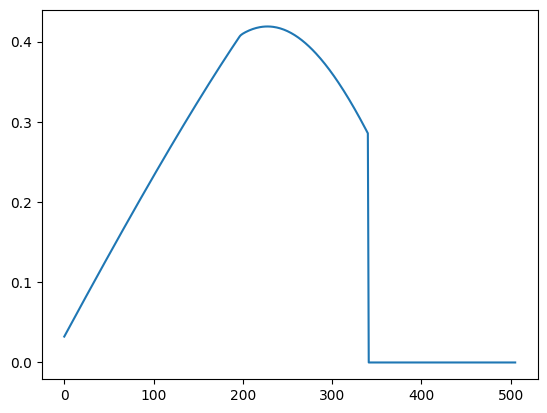

In [31]:
# The line below is mandatory to inform the notebook we want to plot directly in it
%pylab inline

# Plot the left proximeter value recorded by `robot0`
plot(robot0.get_log("left_prox"))

The above figure plot all the left proximeter values recorded from `robot_1`. The x-axis corresponds to the time step of the recording values and the y-axis corresponds to the value of the left proximeter at each time step. The time step depends on the frequency at which we have run the `robot_log` primitive. Above we have set it to 1Hz (one value recorded per second), so in the figure the x-axis represents seconds. If we would have set the frequency of the `robot_log` routine to 2Hz, each unit on the x-axis would then correspond to half a second.

We can indicate the labels of the x and y axes and provide a title for the figure with:

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


Text(0.5, 1.0, 'Plot of left proximeter activation against time')

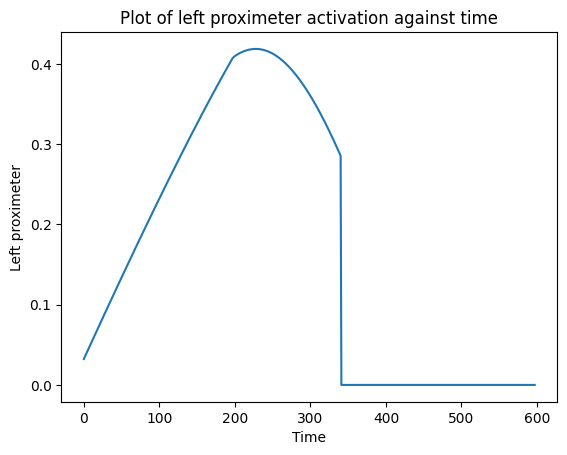

In [32]:
%pylab inline

# Plot the left proximeter value recorded by `robot0` and set labels to the x and y axes, as well as a title
plot(robot0.get_log("left_prox"))
xlabel("Time")
ylabel("Left proximeter")
title("Plot of left proximeter activation against time")

This write the labels and the title on the figure.

Let's now plot the energy level of `robot_1`:

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


Text(0.5, 1.0, 'Plot of energy level against time')

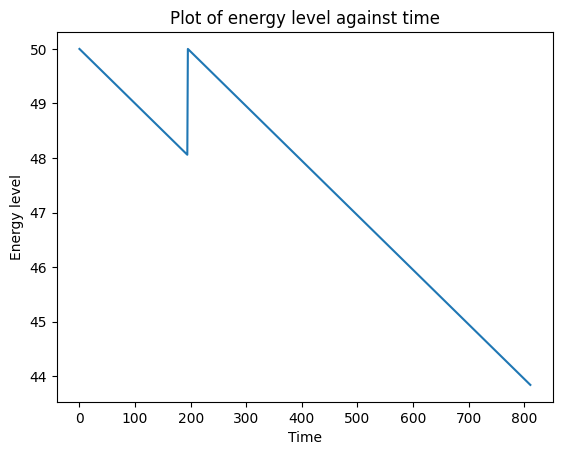

In [34]:
# The line below is mandatory to inform the notebook we want to plot directly in it
%pylab inline

# Plot the energy level recorded by `robot0`
plot(robot0.get_log("energy"))
xlabel("Time")
ylabel("Energy level")
title("Plot of energy level against time")

We can also plot two time series on the same plot. Let's plot the energy levels of both robots:

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


Text(0.5, 1.0, 'Plot of energy level against time')

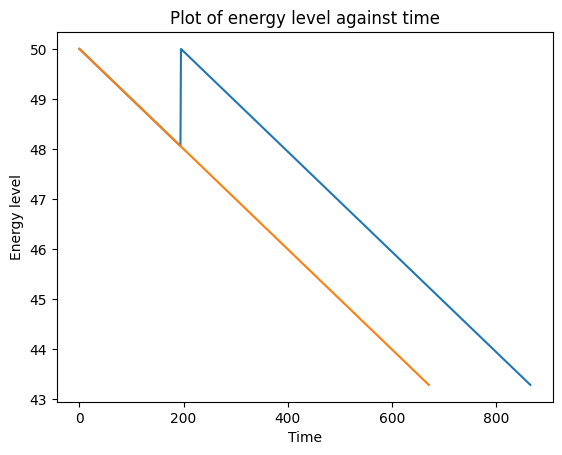

In [35]:
# The line below is mandatory to inform the notebook we want to plot directly in it
%pylab inline

# Plot the energy levels recorded by `robot0` and `robot2`
plot(robot0.get_log("energy"))
plot(robot2.get_log("energy"))
xlabel("Time")
ylabel("Energy level")
title("Plot of energy level against time")

We can add a legend to indicate which line corresponds to which robot:

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


Text(0.5, 1.0, 'Plot of energy level against time')

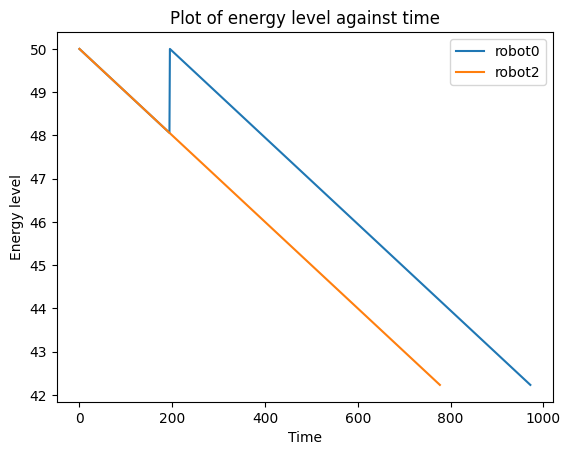

In [36]:
# The line below is mandatory to inform the notebook we want to plot directly in it
%pylab inline

# Plot the energy levels recorded by `robot0` and `robot2`
plot(robot0.get_log("energy"))
plot(robot2.get_log("energy"))
legend(["robot0", "robot2"])

xlabel("Time")
ylabel("Energy level")
title("Plot of energy level against time")

By right-clicking on the figure and choosing "Save image as", you can store it as a PNG image. This is useful if you want to save it for other purposes.

That's all. Don't forget to properly close the session when you have finished with the notebook:

In [37]:
stop_server_and_interface()
controller.stop()